# Overfit and regularization exercises

## 0. Tips data EDA

In [133]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns

a)

In [134]:
df = sns.load_dataset("tips")
df.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [135]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   total_bill  244 non-null    float64 
 1   tip         244 non-null    float64 
 2   sex         244 non-null    category
 3   smoker      244 non-null    category
 4   day         244 non-null    category
 5   time        244 non-null    category
 6   size        244 non-null    int64   
dtypes: category(4), float64(2), int64(1)
memory usage: 7.4 KB


In [136]:
df.describe()

,total_bill,tip,size
count,244.000000,244.000000,244.000000
mean,19.785943,2.998279,2.569672
std,8.902412,1.383638,0.951100
min,3.070000,1.000000,1.000000
25%,13.347500,2.000000,2.000000
50%,17.795000,2.900000,2.000000
75%,24.127500,3.562500,3.000000
max,50.810000,10.000000,6.000000


b)

Text(0.5, 0.98, 'Descriptive statistics for tip, total bill and size')

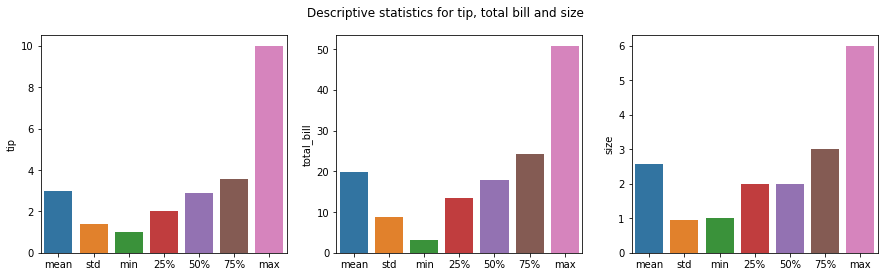

In [137]:
fig, ax = plt.subplots(1, 3, figsize=(15,4))
tip = df["tip"].describe()[1:]
sns.barplot(y=tip, x=tip.index, ax=ax[0])
total_bill = df["total_bill"].describe()[1:]
sns.barplot(y=total_bill, x=total_bill.index, ax=ax[1])
size = df["size"].describe()[1:]
sns.barplot(y=size, x=size.index, ax=ax[2])
fig.suptitle("Descriptive statistics for tip, total bill and size")

c)

Text(0.5, 1.0, 'Male and female distribution')

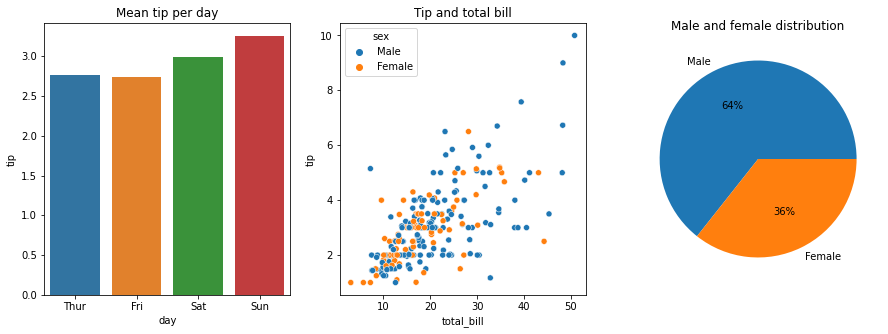

In [138]:
fig, ax = plt.subplots(1,3, figsize=(15,5))

tip_day = df["tip"].groupby(df["day"]).mean()
sns.barplot(x=tip_day.index, y=tip_day, ax=ax[0])
ax[0].set_title("Mean tip per day")

sns.scatterplot(x=df["total_bill"], y=df["tip"], hue=df["sex"], ax=ax[1])
ax[1].set_title("Tip and total bill")

sex = df["sex"].value_counts()
ax[2].pie(sex, labels=sex.index, autopct='%.0f%%')
ax[2].set_title("Male and female distribution")

## 1. Train|test split

In [139]:
from sklearn.model_selection import train_test_split

In [140]:
X, y = df.drop(["tip", "sex", "smoker", "day", "time"], axis=1), df["tip"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((170, 2), (74, 2), (170,), (74,))

## 2. Feature standardization

In [141]:
def standardization(train, test):
    my, sigma = train.mean(), train.std()
    train = (train - my) / sigma
    test = (test - my) / sigma
    return (train, test)

In [142]:
scaled_data = standardization(X_train, X_test)

scaled_X_train = scaled_data[0]
scaled_X_test = scaled_data[1]

print(f"Mean value scaled X_train: [{scaled_X_train['total_bill'].mean()}, {scaled_X_train['size'].mean()}]")
print(f"Mean value scaled X_test: [{scaled_X_test['total_bill'].mean()}, {scaled_X_test['size'].mean()}]")
print(f"Standard deviation scaled X_train: [{scaled_X_train['total_bill'].std()}, {scaled_X_train['size'].std()}]")
print(f"Standard deviation scaled X_test: [{scaled_X_test['total_bill'].std()}, {scaled_X_test['size'].std()}]")

Mean value scaled X_train: [6.791952621236252e-17, -1.9853399969767506e-16]
Mean value scaled X_test: [-0.19137999314331822, -0.044779343239090774]
Standard deviation scaled X_train: [1.0, 0.9999999999999999]
Standard deviation scaled X_test: [0.9249567328013774, 1.0663888876956773]


## 3. Polynomial features

In [143]:
from sklearn.preprocessing import PolynomialFeatures

In [151]:
poly_features = PolynomialFeatures(2, include_bias=False)
poly_X_train = poly_features.fit_transform(scaled_X_train)
poly_X_test = poly_features.transform(scaled_X_test)

test = poly_features.fit_transform(scaled_X_test)
print((poly_X_test == test).sum())
print(poly_X_test.size)


370
370


## 4. Polynomial regression

In [162]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [168]:
def polynomial_regression(degree):
    poly_features = PolynomialFeatures(degree, include_bias=False)
    poly_X_train = poly_features.fit_transform(scaled_X_train)
    poly_X_test = poly_features.transform(scaled_X_test)
    
    model_linear_regression = LinearRegression()
    model_linear_regression.fit(poly_X_train, y_train)
    y_pred_train = model_linear_regression.predict(poly_X_train)
    y_pred_test = model_linear_regression.predict(poly_X_test)

    RMSE_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    RMSE_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

    return (RMSE_train, RMSE_test)


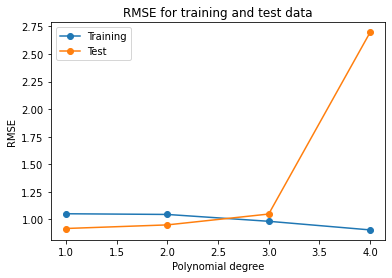

In [231]:
recorded_RMSE = pd.DataFrame(columns=["Training", "Test"], index=[1,2,3,4])

for degree in range(1,5):
    recorded_RMSE.loc[degree] = polynomial_regression(degree)

plt.plot(recorded_RMSE, linestyle="-", marker="o")
plt.legend(recorded_RMSE.columns)
plt.xlabel("Polynomial degree")
plt.ylabel("RMSE")
plt.title("RMSE for training and test data")
plt.show()

## 5. Regularization methods

In [221]:
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [277]:
def evaluation(model, y_pred):
    MAE = mean_absolute_error(y_test, y_pred)
    MSE = mean_squared_error(y_test, y_pred)
    RMSE = np.sqrt(MSE)
    weights =  model.coef_
    alpha = model.alpha_

    np.set_printoptions(precision=5)
    print(f"Alpha: {alpha}")
    print(f"Weights: {weights}")
    print(f"MAE: {MAE:.3f}")
    print(f"MSE: {MSE:.3f}")
    print(f"RMSE: {RMSE:.3f}")

a)

In [280]:
# Polynomial with 4 degrees
poly_features = PolynomialFeatures(4, include_bias=False)
poly_X_train = poly_features.fit_transform(scaled_X_train)
poly_X_test = poly_features.transform(scaled_X_test)

# RidgeCV
model_ridgeCV = RidgeCV(alphas=[0.01,0.1,0.5,1,5,10])
model_ridgeCV.fit(poly_X_train, y_train)
y_pred_ridgeCV = model_ridgeCV.predict(poly_X_test)

evaluation(model_ridgeCV, y_pred_ridgeCV)

Alpha: 5.0
Weights: [ 0.9147   0.23894 -0.67584  0.20551 -0.01369 -0.26008  0.31868 -0.0343
 -0.12484  0.16    -0.18105  0.24878 -0.12693  0.05003]
MAE: 0.831
MSE: 2.208
RMSE: 1.486


b)

In [281]:
# LassoCV
model_lassoCV = LassoCV(n_alphas=100, max_iter=1e4)
model_lassoCV.fit(poly_X_train, y_train)
y_pred_lassoCV = model_lassoCV.predict(poly_X_test)

evaluation(model_lassoCV, y_pred_lassoCV)

Alpha: 0.20770232166587632
Weights: [ 0.2347   0.      -0.      -0.       0.       0.08815  0.09736  0.
  0.0322   0.       0.       0.      -0.       0.     ]
MAE: 0.823
MSE: 1.345
RMSE: 1.160


c)

In [283]:
# ElasticNetCV
model_elasticCV = ElasticNetCV(n_alphas=100, l1_ratio=[.001,.01,.05,.1,.5,.9,.95,1], max_iter=1e4)
model_elasticCV.fit(poly_X_train, y_train)
y_pred_elasticCV = model_elasticCV.predict(poly_X_test)

evaluation(model_elasticCV, y_pred_elasticCV)
print(f"l1 ratio: {model_elasticCV.l1_ratio_}")

Alpha: 0.10711875299553128
Weights: [ 0.51937  0.09959 -0.21442  0.       0.       0.       0.11409  0.
  0.01801  0.03755  0.       0.       0.       0.     ]
MAE: 0.761
MSE: 1.298
RMSE: 1.139
l1 ratio: 0.9
